## DATA UNDERSTANDING

#### **Projeto:**  
Elaboração de um modelo de análise das métricas RFV (Recência, Frequência, Valor).
 

#### **Introdução:**  
As estratégias de marketing de um e-commerce envolvem várias abordagens e ferramentas que visam aumentar a visibilidade, atrair clientes e gerar vendas.

#### **Obejetivos:**  
1. Agrupar os clientes em clusters com base no comportamento em compras levando em consideração o RFM (Recency, Frequency, Monetery Value);  

2. Identificar padrões e características em comum entre os clientes, como: 

- Clientes que compram os mesmos produtos;  

- Clientes que possuem a mesma frequência de compras;  

- Clientes que gastam mais dinheiro em suas compras.  

3. Gerar insights para segmentação de clientes e personalisação das campanhas de marketing, com base no comportamento de compras;  

#### **Dados:**

1 . Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.  

2. Organização do arquivo .csv:

| Coluna      | Descrição                                | Tipo     |
|-------------|------------------------------------------|----------|
| InvoiceNo   | Identificação da transação               | Int      |
| StockCode   | Código de estoque do produto             | String   |
| Description | Descrição do produto                     | String   |
| Quantity    | Quantidade de produtos por transação    | Int      |
| InvoiceDate | Data da transação                        | Datetime |
| UnitPrice   | Preço unitário do produto                | Float    |
| CustomerID  | Identificação do cliente                 | Int      |
| Country     | País de origem da transação              | String   |








### 1. Importação de Bibliotecas

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from src.visualizations.plot_results import plot_box_and_bar_spark, plot_histograms, plot_qq_pyspark, plot_rfm_relationships
from src.data.process_data import analisar_qualidade_dados_spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

### 2. Inicialização da SparkSession e Carregamento dos Dados

In [2]:
df = pd.read_csv("project/src/data/raw/data.csv", encoding="latin1", sep=";")
print(df.head())

  InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0  536365,85123A,WHITE HANGING HEART T-LIGHT HOLD...                               
1  536365,71053,WHITE METAL LANTERN,6,12/1/2010 8...                               
2  536365,84406B,CREAM CUPID HEARTS COAT HANGER,8...                               
3  536365,84029G,KNITTED UNION FLAG HOT WATER BOT...                               
4  536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6...                               


In [3]:

# Configuração do Spark com KryoSerializer
spark = SparkSession.builder \
    .appName("Data Processing") \
    .appName("Parquet Manipulation") \
    .appName("CSV para Parquet") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrationRequired", "false") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

# Caminho absoluto para o arquivo CSV
project_path = os.path.abspath("project/src/data/raw/data.csv")

# Ler o CSV com codificação e delimitador ajustados
df = spark.read.csv(
    project_path,
    header=True,
    inferSchema=True
)

# Mostrar os primeiros registros (opcional)
df.show(5, truncate=False)

# Salvar como Parquet
output_path = os.path.abspath("project/src/data/raw/data.parquet")
df.write.mode("overwrite").parquet(output_path)



25/01/30 12:30:06 WARN Utils: Your hostname, Mac.local resolves to a loopback address: 127.0.0.1; using 192.168.2.3 instead (on interface en5)
25/01/30 12:30:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/30 12:30:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

##### Carregando base de dados

In [4]:
input_path = "project/src/data/raw/data.parquet/"  # Caminho para o diretório
df = spark.read.parquet(input_path)
df.show(5, truncate=False)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|549251   |84596F   |SMALL MARSHMALLOWS PINK BOWL       |2       |4/7/2011 12:16|0.42     |14449     |United Kingdom|
|549251   |21975    |PACK OF 60 DINOSAUR CAKE CASES     |1       |4/7/2011 12:16|0.55     |14449     |United Kingdom|
|549251   |22417    |PACK OF 60 SPACEBOY CAKE CASES     |1       |4/7/2011 12:16|0.55     |14449     |United Kingdom|
|549251   |22326    |ROUND SNACK BOXES SET OF4 WOODLAND |1       |4/7/2011 12:16|2.95     |14449     |United Kingdom|
|549251   |22327    |ROUND SNACK BOXES SET OF 4 SKULLS  |1       |4/7/2011 12:16|2.95     |14449     |United Kingdom|
+---------+---------+-----------------------------------

### 2. Análise de Dados

#### Número de linhas e colunas

In [5]:
print(f"Número de linhas: {df.count()}")
print(f"Número de colunas: {len(df.columns)}")

Número de linhas: 541909
Número de colunas: 8


#### Esparsidade

In [6]:
analisar_qualidade_dados_spark(df)

Coluna,Zeros,Valores Vazios,Esparsidade
InvoiceNo,0,0,0.00%
StockCode,0,0,0.00%
Description,0,1454,0.27%
Quantity,0,0,0.00%
InvoiceDate,0,0,0.00%
UnitPrice,2515,0,0.46%
CustomerID,0,135080,24.93%
Country,0,0,0.00%


#### Análise de Variável Individual

#### InvoiceNo  


In [7]:
valores_unicos_InvoiceNo= df.select("InvoiceNo").distinct().count()
print(f"Valores únicos de InvoiceNo: {valores_unicos_InvoiceNo} ")

Valores únicos de InvoiceNo: 25900 


#### Description

In [8]:
valores_unicos_Description= df.select("Description").distinct().count()
print(f"Valores únicos de Description: {valores_unicos_Description} ")

Valores únicos de Description: 4224 


#### StockCode

In [9]:
df.groupBy("StockCode").count().orderBy("count", ascending=False).show(10)  # Top 10 produtos mais vendidos

+---------+-----+
|StockCode|count|
+---------+-----+
|   85123A| 2313|
|    22423| 2203|
|   85099B| 2159|
|    47566| 1727|
|    20725| 1639|
|    84879| 1502|
|    22720| 1477|
|    22197| 1476|
|    21212| 1385|
|    20727| 1350|
+---------+-----+
only showing top 10 rows



<Axes: title={'center': 'Top 10 Produtos Mais Vendidos'}, xlabel='StockCode'>

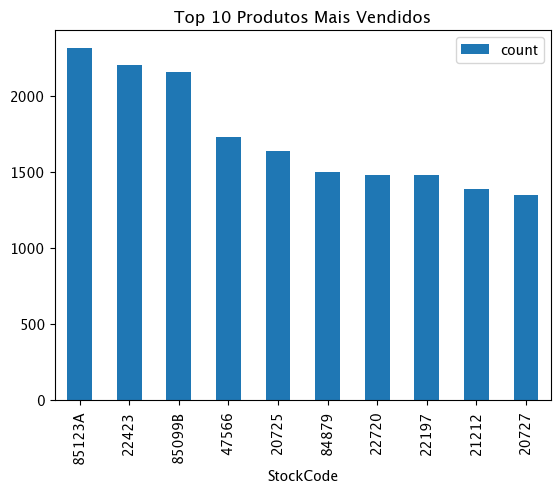

In [10]:
stock_freq = df.groupBy("StockCode").count().orderBy("count", ascending=False).toPandas()
stock_freq.head(10).plot(kind='bar', x='StockCode', y='count', title='Top 10 Produtos Mais Vendidos')

#### InvoiceDate

In [11]:
df.select(min("InvoiceDate"), max("InvoiceDate")).show()  # Período coberto pelos dados

+----------------+----------------+
|min(InvoiceDate)|max(InvoiceDate)|
+----------------+----------------+
| 1/10/2011 10:04|   9/9/2011 9:52|
+----------------+----------------+



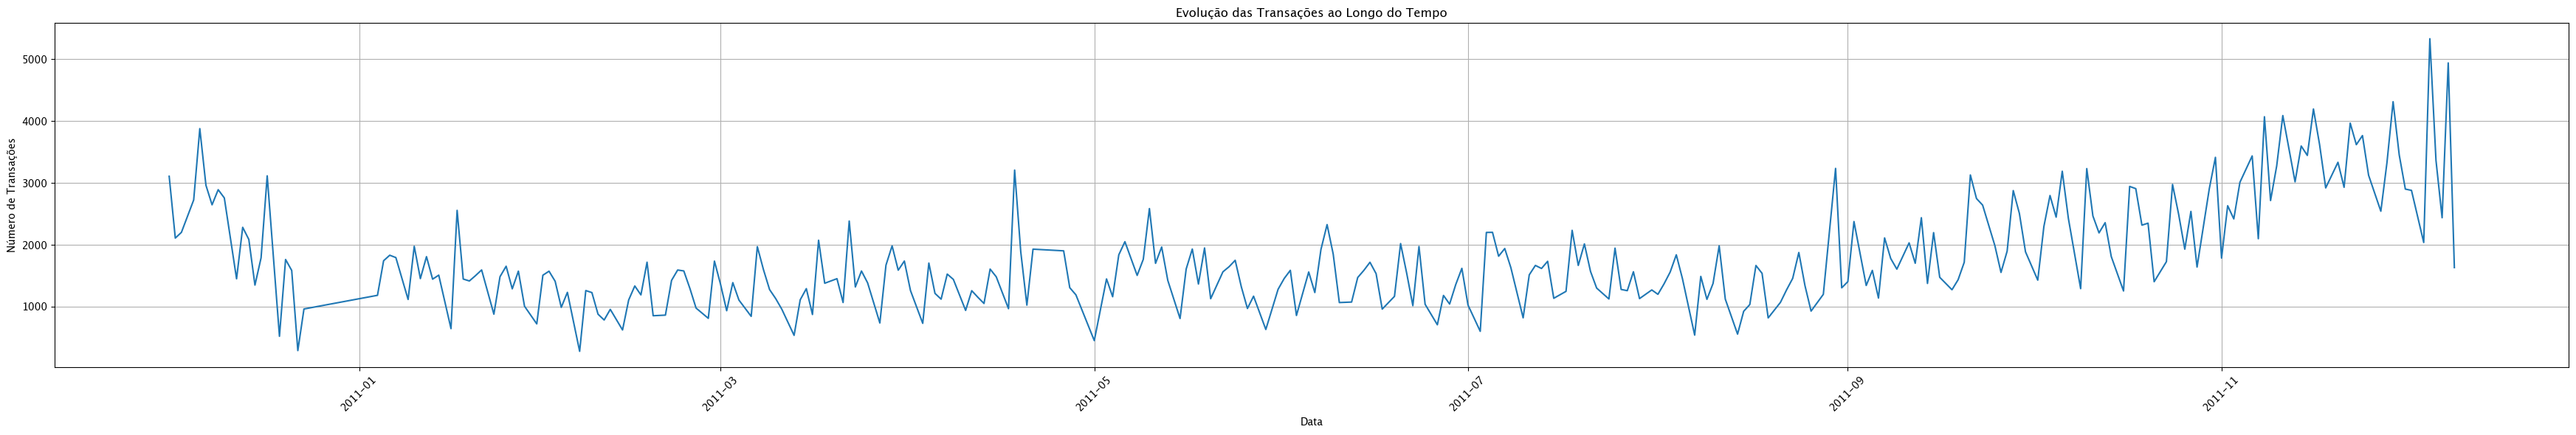

In [12]:
df_pandas = df.toPandas()


df_pandas['InvoiceDate'] = pd.to_datetime(df_pandas['InvoiceDate'])


daily_data = df_pandas.groupby(df_pandas['InvoiceDate'].dt.date).size()

# Criar o gráfico de linha
plt.figure(figsize=(35,6))
plt.plot(daily_data.index, daily_data.values)
plt.title('Evolução das Transações ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Country

In [13]:
df.groupBy("Country").count().orderBy("count", ascending=False).show(10)  # Top 10 países com mais transações

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|495478|
|       Germany|  9495|
|        France|  8557|
|          EIRE|  8196|
|         Spain|  2533|
|   Netherlands|  2371|
|       Belgium|  2069|
|   Switzerland|  2002|
|      Portugal|  1519|
|     Australia|  1259|
+--------------+------+
only showing top 10 rows



<Axes: title={'center': 'Transações por País'}, xlabel='Country'>

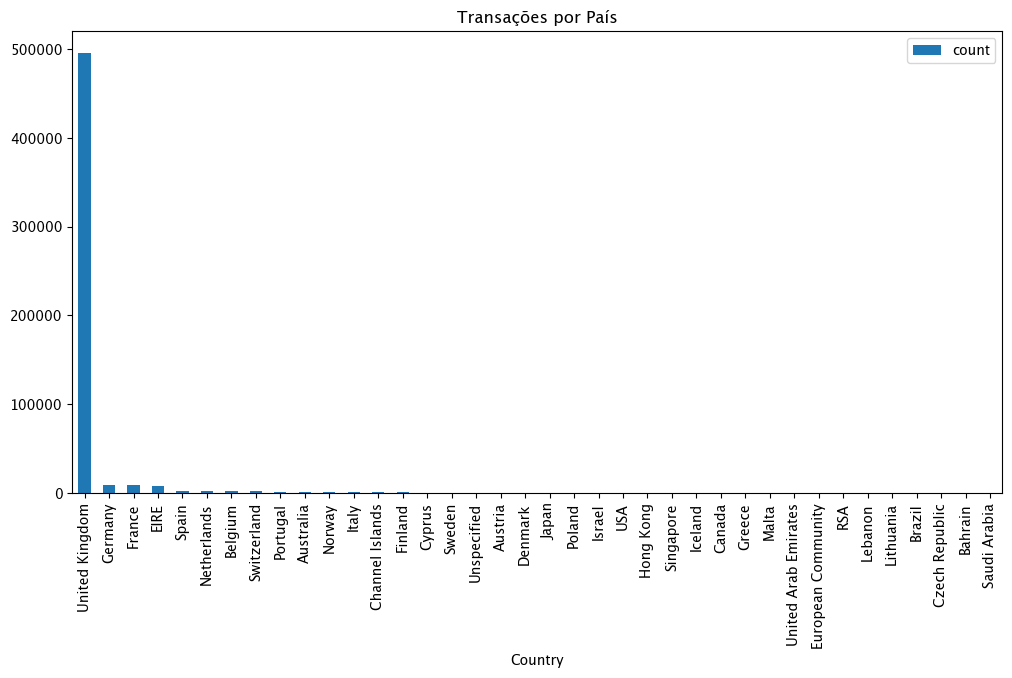

In [14]:
country_freq = df.groupBy("Country").count().orderBy("count", ascending=False).toPandas()
country_freq.plot(kind='bar', x='Country', y='count', figsize=(12, 6), title='Transações por País')

#### UnitPrice

In [15]:
df.describe(["UnitPrice"]).show()

+-------+-----------------+
|summary|        UnitPrice|
+-------+-----------------+
|  count|           541909|
|   mean|4.611113626089708|
| stddev|96.75985306117961|
|    min|        -11062.06|
|    max|          38970.0|
+-------+-----------------+



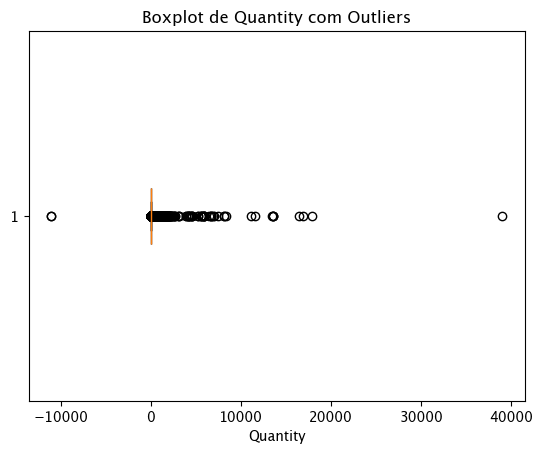

In [16]:
quantities = df.select("UnitPrice").rdd.flatMap(lambda x: x).collect()

# Criar o boxplot
plt.boxplot(quantities, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))
plt.title("Boxplot de Quantity com Outliers")
plt.xlabel("Quantity")
plt.show()

In [17]:
print(f"Medidas de posição: ")
# Cálculo da mediana
median_UnitPrice = df.approxQuantile("UnitPrice", [0.5], 0.01)[0]
print(f"\nMediana de UnitPrice: {median_UnitPrice}")

# Cálculo dos interquantis Q1 e Q3 para unitPrice
q1, q2, q3 = df.approxQuantile("UnitPrice", [0.25, 0.5, 0.75], 0.01)
print(f"Q1 de UnitPrice: {q1}\nQ2 de UnitPrice: {q2}\nQ3 de UnitPrice: {q3}")

Medidas de posição: 

Mediana de UnitPrice: 2.08
Q1 de UnitPrice: 1.25
Q2 de UnitPrice: 2.08
Q3 de UnitPrice: 4.13


#### Detectar outliers em UnitPrice

In [18]:
# Calcular os limites ajustados
iqr_UnitPrice = q3 - q1  # IQR para UnitPrice

# Ajustar o limite inferior para no mínimo 0 usando `greatest`
lower_UnitPrice_bound = F.greatest(F.lit(0), F.lit(q1) - 1.5 * F.lit(iqr_UnitPrice))
upper_UnitPrice_bound = F.lit(q3) + 1.5 * F.lit(iqr_UnitPrice)

# Adicionar os limites ao DataFrame, se necessário
df = df.withColumn("lower_UnitPrice_bound", lower_UnitPrice_bound).withColumn("upper_UnitPrice_bound", upper_UnitPrice_bound)

# Filtrar os outliers (fora dos limites ajustados)
outliers_df = df.filter((col("UnitPrice") < col("lower_UnitPrice_bound")) | (col("UnitPrice") > col("upper_UnitPrice_bound")))

# Mostrar os outliers
outliers_df.show()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+---------------------+---------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|lower_UnitPrice_bound|upper_UnitPrice_bound|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+---------------------+---------------------+
|   549255|    21623|VINTAGE UNION JAC...|       2|4/7/2011 12:23|     9.95|     16209|United Kingdom|                  0.0|                 8.45|
|   549257|    22770|      MIRROR CORNICE|       1|4/7/2011 12:29|    14.95|     14465|United Kingdom|                  0.0|                 8.45|
|   549257|    20748|KENSINGTON COFFEE...|       1|4/7/2011 12:29|    12.75|     14465|United Kingdom|                  0.0|                 8.45|
|   549257|    22635|CHILDS BREAKFAST ...|       1|4/7/2011 12:29|     9.95|     14465|United Kingdom|                

#### Quantity

In [19]:
df.describe(["Quantity"]).show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            541909|
|   mean|  9.55224954743324|
| stddev|218.08115785023438|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



In [20]:
print(f"Medidas de posição: ")
# Cálculo da mediana
median_quantity = df.approxQuantile("Quantity", [0.5], 0.01)[0]
print(f"\nMediana de Quantity: {median_quantity}")

# Cálculo dos interquantis Q1 e Q3 para unitPrice
q1, q2, q3 = df.approxQuantile("Quantity", [0.25, 0.5, 0.75], 0.01)
print(f"Q1 de Quantity: {q1}\nQ2 de Quantity: {q2}\nQ3 de Quantity: {q3}")

Medidas de posição: 



Mediana de Quantity: 3.0
Q1 de Quantity: 1.0
Q2 de Quantity: 3.0
Q3 de Quantity: 10.0


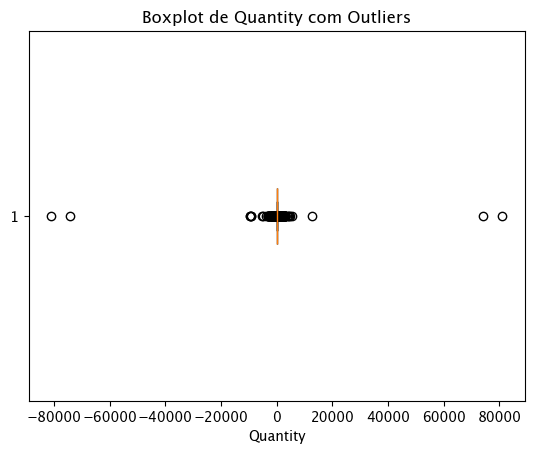

In [21]:
quantities = df.select("Quantity").rdd.flatMap(lambda x: x).collect()

# Criar o boxplot
plt.boxplot(quantities, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))
plt.title("Boxplot de Quantity com Outliers")
plt.xlabel("Quantity")
plt.show()

Detectar outliers em Quantity

In [22]:
# Calcular os limites ajustados
iqr_Quantity = q3 - q1  # IQR para Quantity

# Ajustar o limite inferior para no mínimo 0 usando `greatest`
lower_Quantity_bound = F.greatest(F.lit(0), F.lit(q1) - 1.5 * F.lit(iqr_Quantity))
upper_Quantity_bound = F.lit(q3) + 1.5 * F.lit(iqr_Quantity)

# Adicionar os limites ao DataFrame, se necessário
df = df.withColumn("lower_Quantity_bound", lower_Quantity_bound).withColumn("upper_Quantity_bound", upper_Quantity_bound)

# Filtrar os outliers (fora dos limites ajustados)
outliers_df = df.filter((col("Quantity") < col("lower_Quantity_bound")) | (col("Quantity") > col("upper_Quantity_bound")))

# Mostrar os outliers
outliers_df.show()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+---------------------+---------------------+--------------------+--------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|lower_UnitPrice_bound|upper_UnitPrice_bound|lower_Quantity_bound|upper_Quantity_bound|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+---------------------+---------------------+--------------------+--------------------+
|  C549252|    22665|RECIPE BOX BLUE S...|      -3|4/7/2011 12:18|     2.55|     16584|United Kingdom|                  0.0|                 8.45|                 0.0|                23.5|
|  C549252|    22666|RECIPE BOX PANTRY...|      -3|4/7/2011 12:18|     2.55|     16584|United Kingdom|                  0.0|                 8.45|                 0.0|                23.5|
|  C549252|    22667|RECIPE BOX RETROS...|      -5|4/7/

#### Análise entre variáveis categóricas

Relação entre variáveis "contínuas"

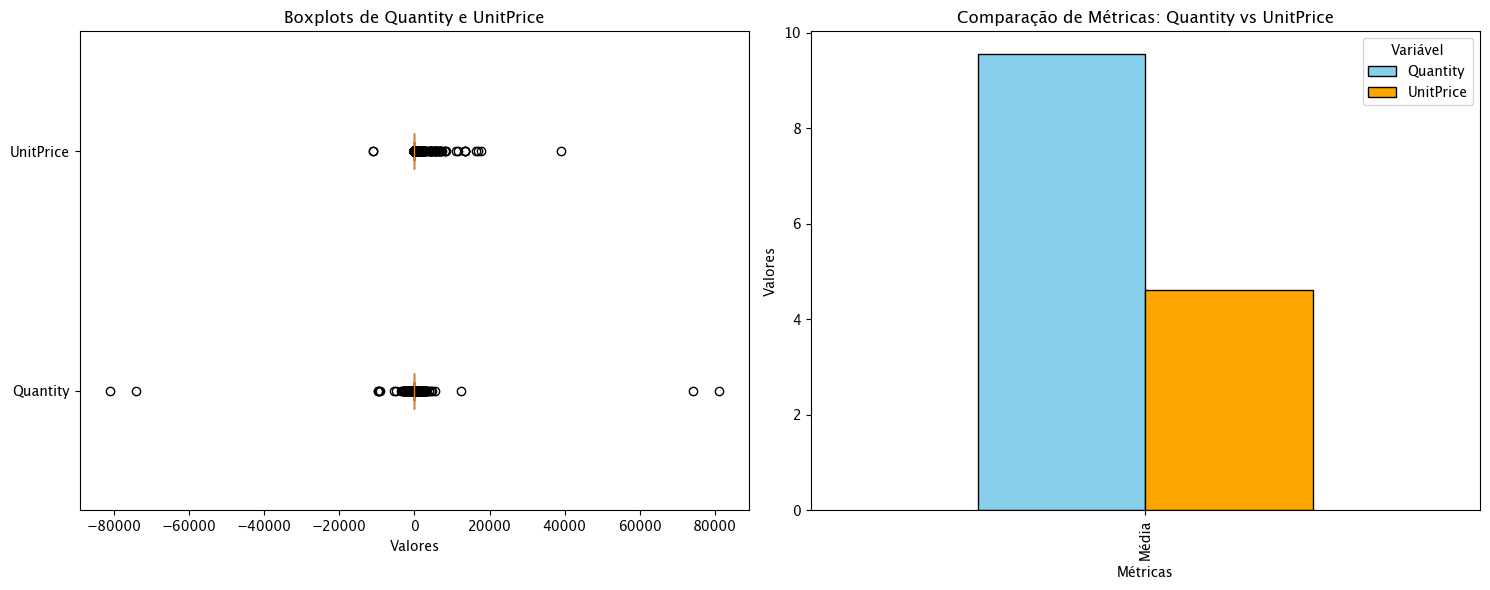

In [23]:
plot_box_and_bar_spark(df, "Quantity", "UnitPrice")

#### Análise de correlação

25/01/30 12:30:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


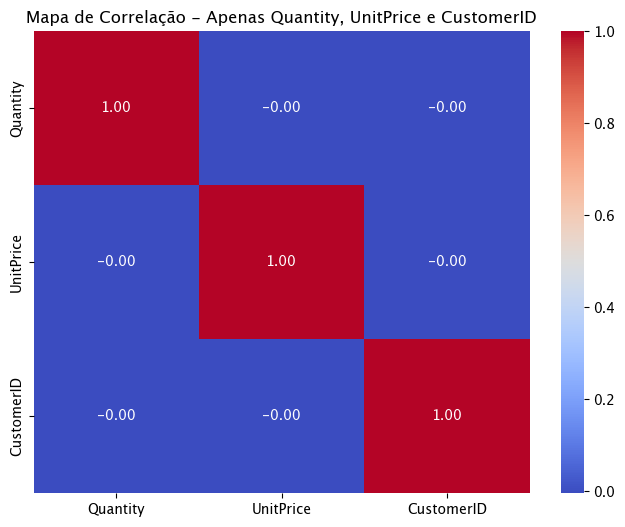

In [24]:
selected_columns = ["Quantity", "UnitPrice", "CustomerID"]
df_selected = df.select(selected_columns).dropna()  


vec_assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df_vec = vec_assembler.transform(df_selected).select("features")

correlation_matrix = Correlation.corr(df_vec, "features").head()[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix, index=selected_columns, columns=selected_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Correlação - Apenas Quantity, UnitPrice e CustomerID")
plt.show()

### 3. Salvando os Dados para Data Preparation

In [25]:
# Obter os valores reais dos limites calculados
lower_Quantity_bound = df.select(lower_Quantity_bound).first()[0]
upper_Quantity_bound = df.select(upper_Quantity_bound).first()[0]
lower_UnitPrice_bound = df.select(lower_UnitPrice_bound).first()[0]
upper_UnitPrice_bound = df.select(upper_UnitPrice_bound).first()[0]


In [26]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/interim
src_path = os.path.join(project_path, 'RID184082_Desafio07/project/src/data/interim')


# Salvar arquivos diretamente na pasta correta
joblib.dump(lower_Quantity_bound, os.path.join(src_path, 'lower_Quantity_bound.pkl'))
joblib.dump(upper_Quantity_bound, os.path.join(src_path, 'upper_Quantity_bound.pkl'))
joblib.dump(lower_UnitPrice_bound, os.path.join(src_path, 'lower_UnitPrice_bound.pkl'))
joblib.dump(upper_UnitPrice_bound, os.path.join(src_path, 'upper_UnitPrice_bound.pkl'))
print("Dados salvos com sucesso!")

Dados salvos com sucesso!


In [27]:
print(f"Caminho completo gerado: {src_path}")
spark.stop()

Caminho completo gerado: /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/interim
